In [0]:
%matplotlib inline

In [2]:
!git clone https://github.com/dfm/exoplanet

Cloning into 'exoplanet'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 7308 (delta 2), reused 14 (delta 2), pack-reused 7294
Receiving objects: 100% (7308/7308), 274.18 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (4374/4374), done.


In [0]:
import os

In [0]:
os.chdir('/content/exoplanet')

In [18]:
!pip install corner

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11643 sha256=a4d84dbae254e50c8cd44d12ad63cd3eb5e1b8f608cec23c62953d50766a528d
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [5]:
!pip install -r requirements.txt

     |████████████████████████████████| 6.3MB 8.9MB/s 
     |████████████████████████████████| 235kB 48.5MB/s 
  Created wheel for rebound-pymc3: filename=rebound_pymc3-0.0.3-cp36-none-any.whl size=22323 sha256=7190b6403d5293df7bf099b69cd87e764a4f5d0faa199e39a814925f1e72b86c
  Stored in directory: /root/.cache/pip/wheels/62/39/dd/45d51f03ee2b1c044c89fcf3a08cb0496734605d7b9ef4e5b6
  Created wheel for rebound: filename=rebound-3.10.1-cp36-cp36m-linux_x86_64.whl size=509662 sha256=128cd2ba9db5f093dcd76265f32a1fb5bb03775debcab49fbcb88472523b002e
  Stored in directory: /root/.cache/pip/wheels/78/df/b1/b59b0fa4adeb58d3724936fd1f9485849a6a304fbd1f2d61ed
Successfully built rebound-pymc3 rebound
  Found existing installation: astropy 3.0.5
    Uninstalling astropy-3.0.5:
      Successfully uninstalled astropy-3.0.5


In [6]:
!pip install git+https://github.com/dfm/exoplanet

  Cloning https://github.com/dfm/exoplanet to /tmp/pip-req-build-8tn2fnpe
  Running command git clone -q https://github.com/dfm/exoplanet /tmp/pip-req-build-8tn2fnpe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for exoplanet: filename=exoplanet-0.2.2.dev13+gd9a46cc-cp36-none-any.whl size=1704152 sha256=ab1701f5ab5d8ac0cafa4868723ca02e6c010e3d67826455c75fbdea327c32bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmxqqwz0/wheels/61/21/2d/22094e4168f84ffa10e3d8dd55f5d3610899711530a5fe1216
Successfully built exoplanet


# Move to notebooks directory and run setup

In [0]:
os.chdir('/content/exoplanet/docs/notebooks')

In [0]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

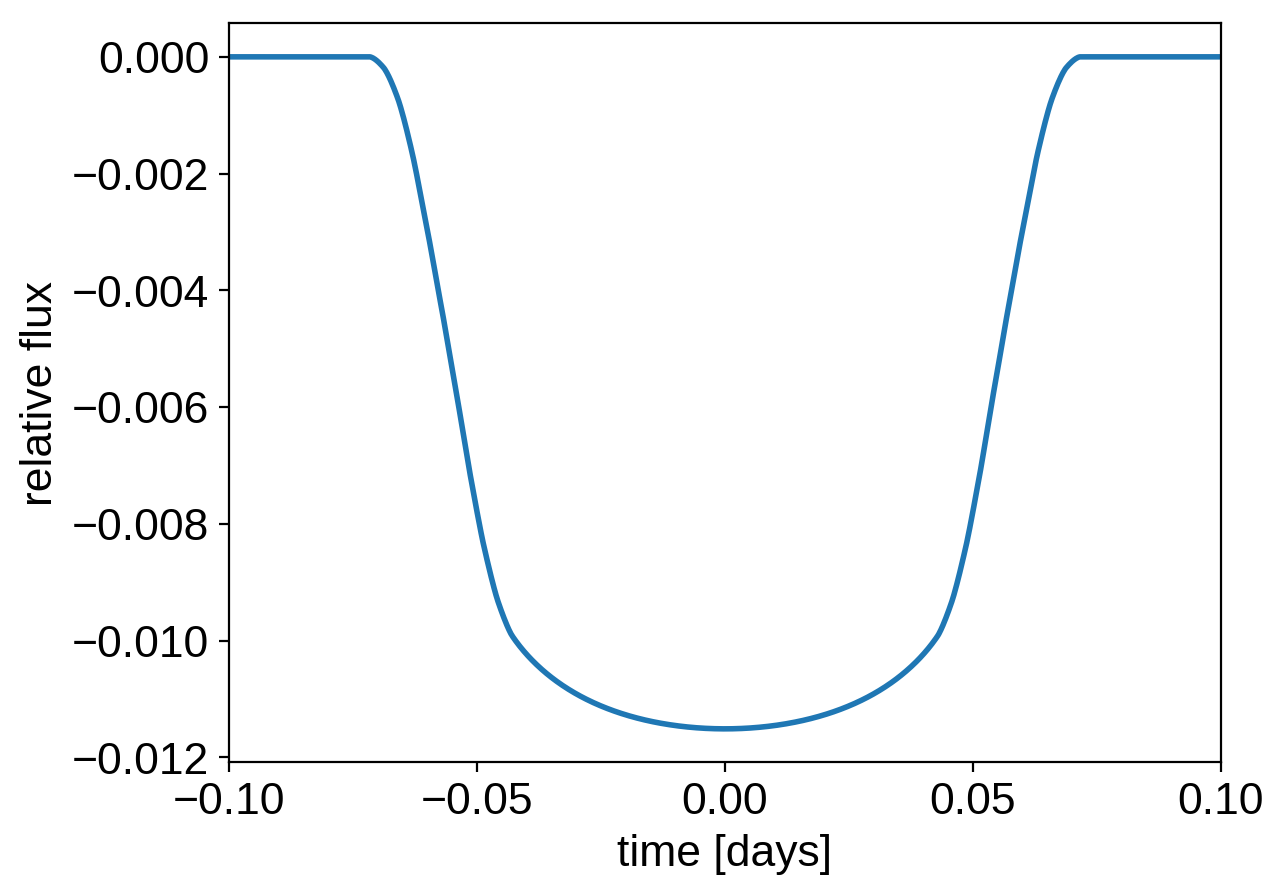

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02).eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [0]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [12]:
from multiprocessing import cpu_count
print(f'This instance has {cpu_count()} CPUs')

This instance has 2 CPUs


In [13]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06]))
    b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
59it [00:07,  8.42it/s, logp=2.479354e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.539425611194


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

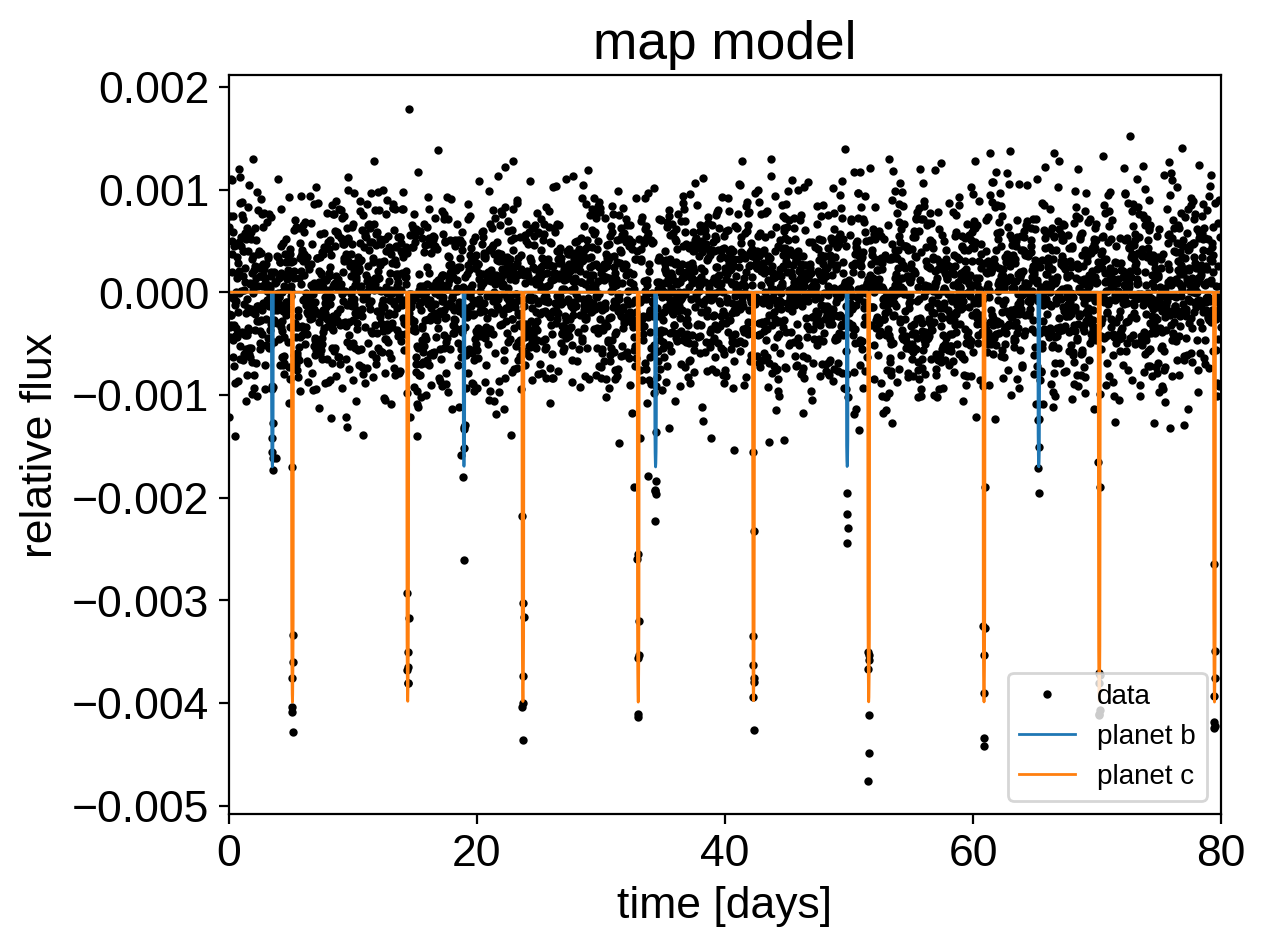

In [14]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [15]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, logP, t0, mean]
100%|██████████| 6000/6000 [01:26<00:00, 69.58it/s]


After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [16]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447965,0.002260,3.273025e-05,15.443385,15.452113,4667.938789,1.000270
period__1,9.292482,0.000299,3.113200e-06,9.291909,9.293071,10151.449015,0.999921
t0__0,3.502995,0.005748,8.387547e-05,3.492509,3.514587,4768.081424,1.000082
t0__1,5.121255,0.001345,1.193193e-05,5.118645,5.123965,12988.411062,0.999904
r__0,0.039605,0.001573,2.137202e-05,0.036358,0.042514,5060.395533,1.000701
r__1,0.058492,0.001061,1.538079e-05,0.056425,0.060426,5028.007696,1.000487
b__0,0.670398,0.047016,8.270379e-04,0.570809,0.740492,3176.995683,1.001184
b__1,0.403300,0.038256,5.749524e-04,0.326370,0.469281,4886.284447,1.000600
u__0,0.373998,0.208948,2.402934e-03,0.000200,0.727491,8353.999093,0.999929
u__1,0.272769,0.344462,4.975827e-03,-0.339671,0.858036,5064.424825,1.000145


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

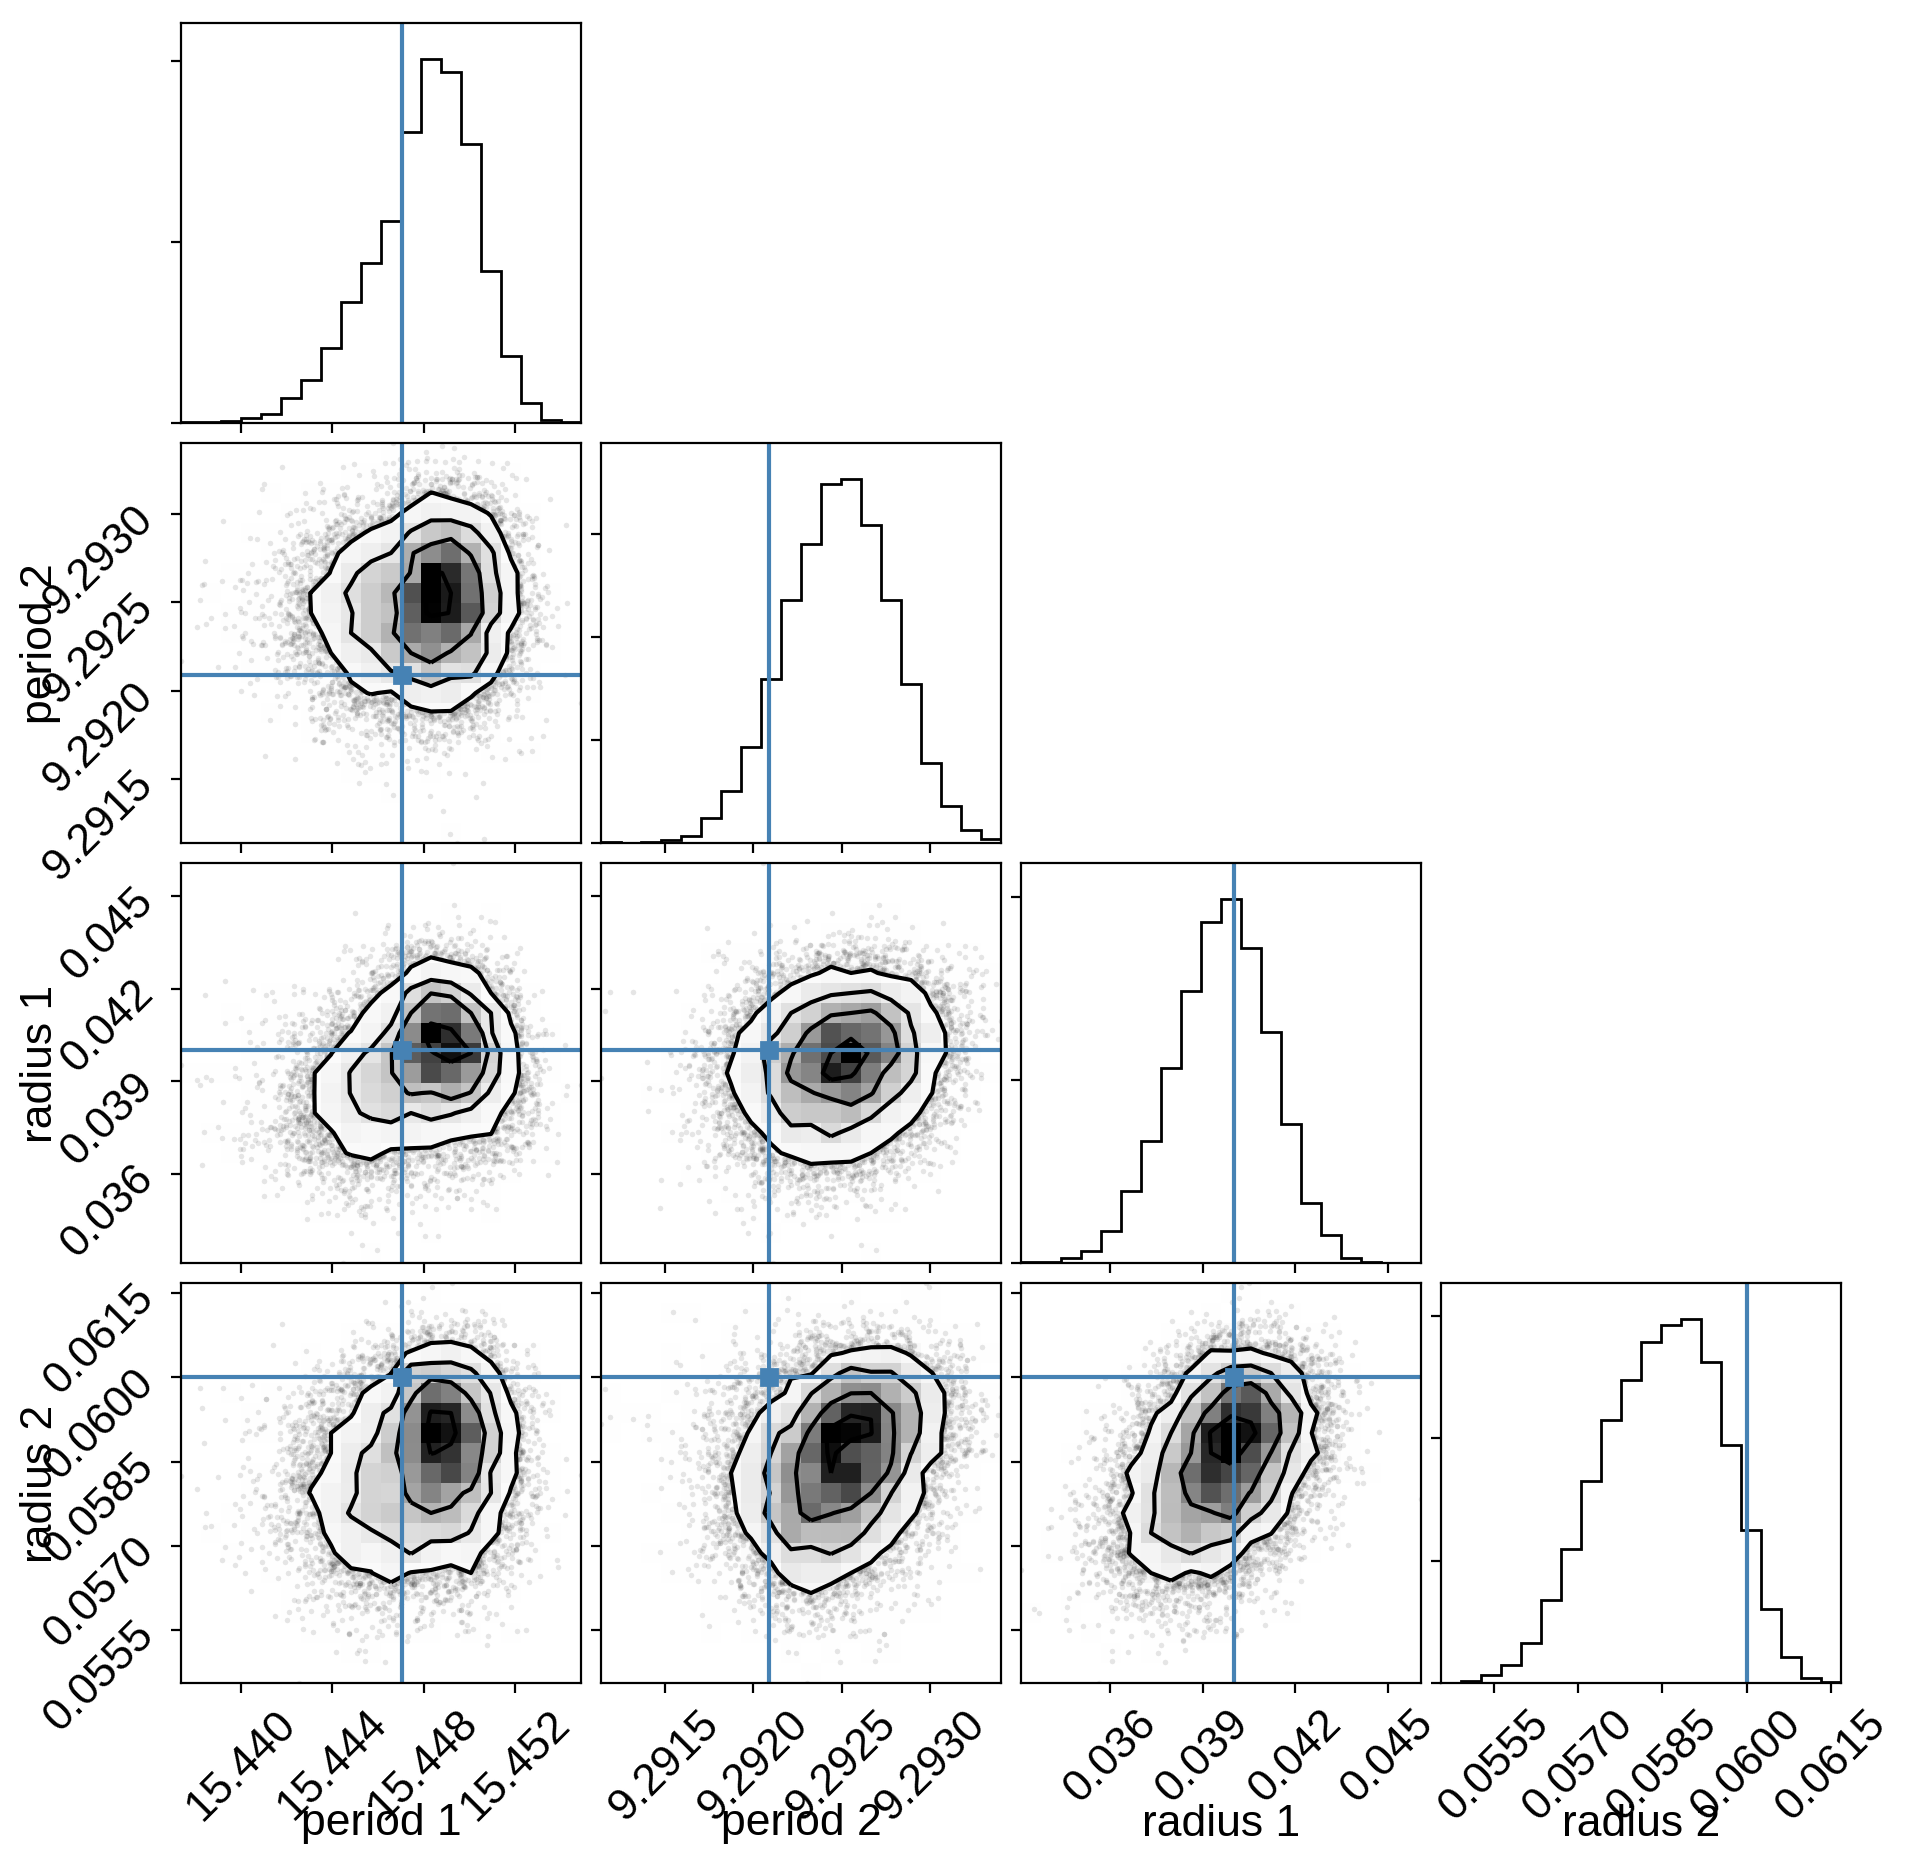

In [19]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]
);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

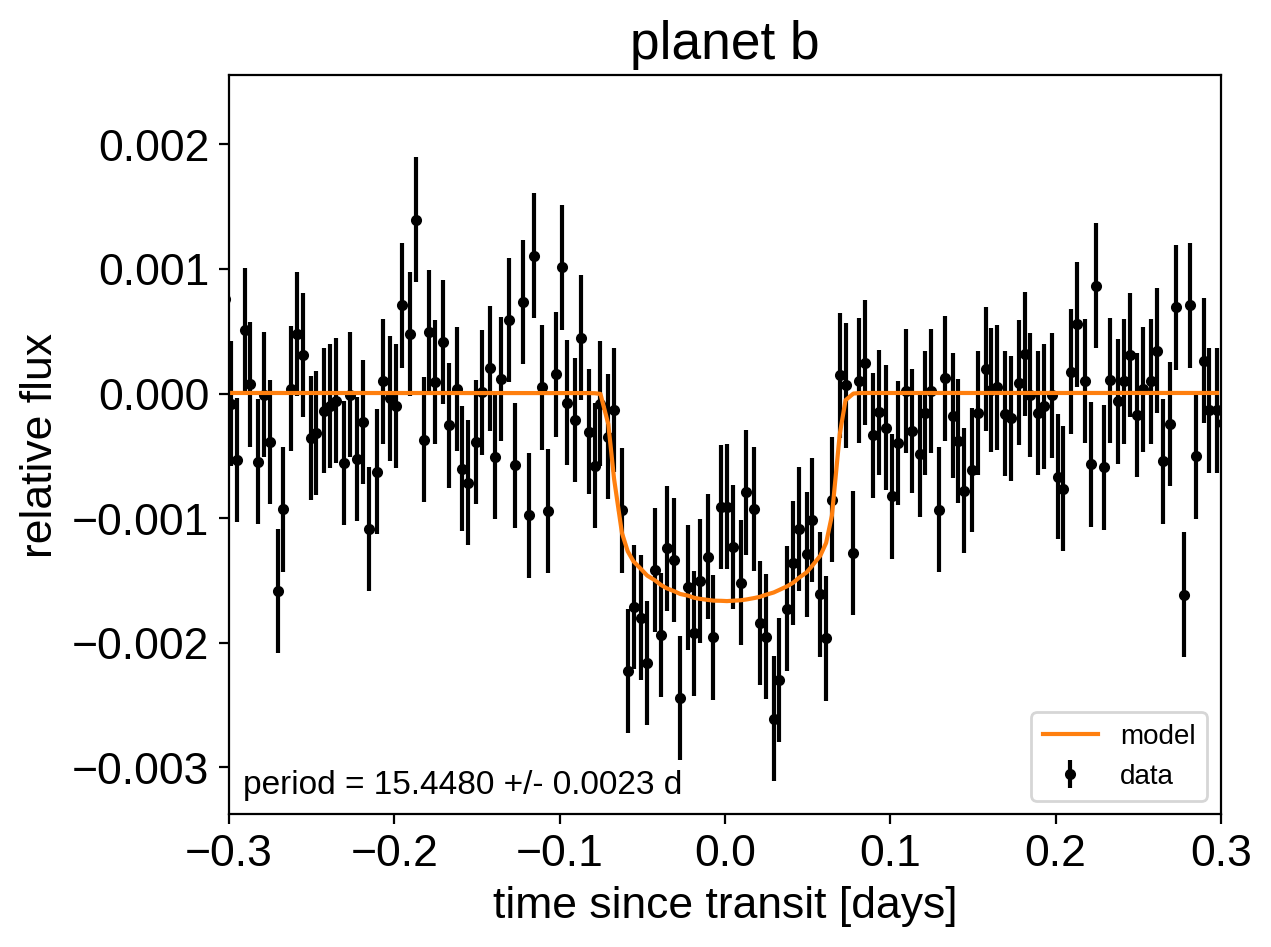

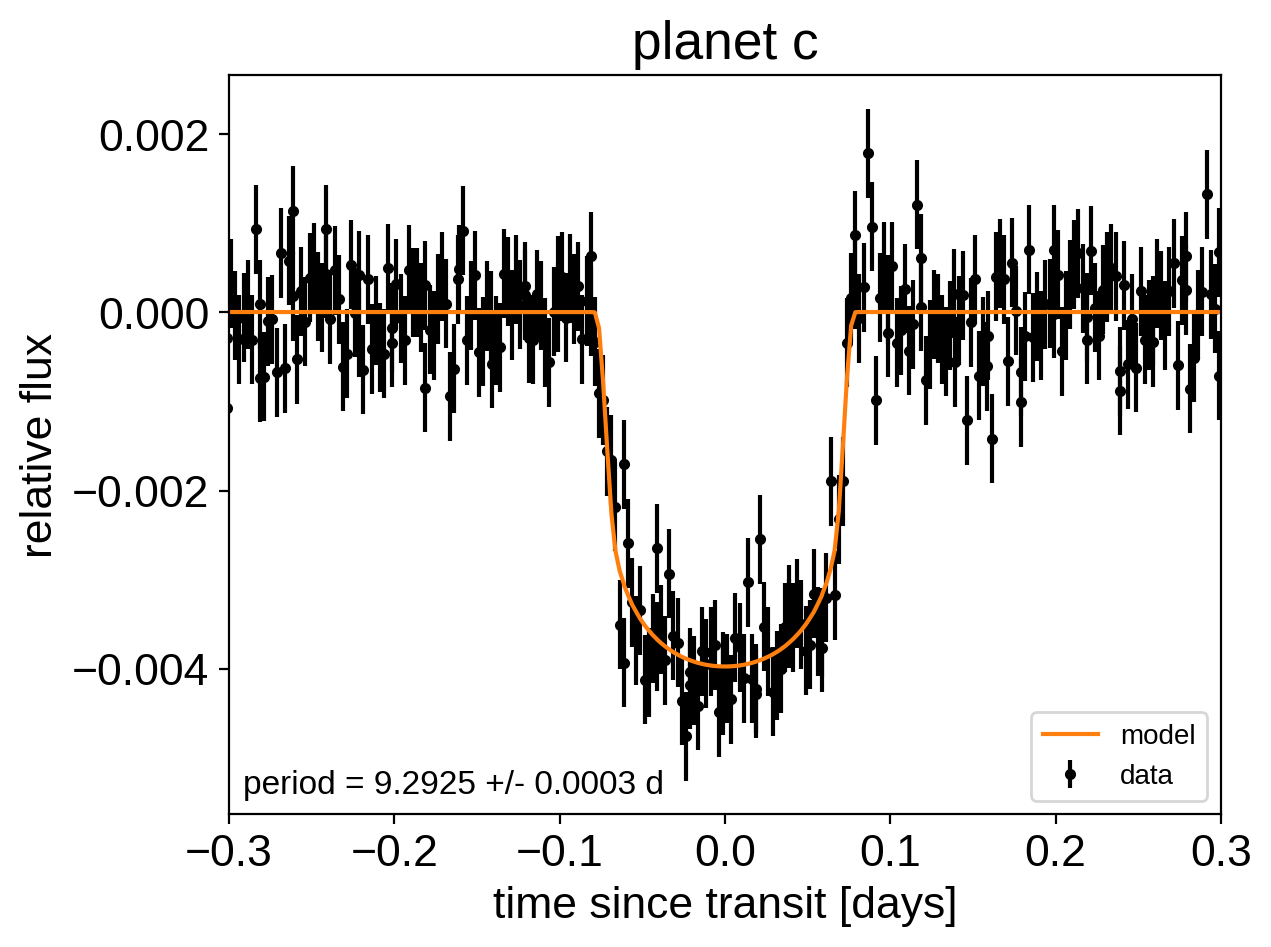

In [20]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [21]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [22]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
